# 1. データを見てみよう で作成した図を出力するサンプルコード

本ノートブックは，1章に掲載した図を出力するためのサンプルコードです．
- e-Stat の家計調査データを使用
- 牛肉，豚肉，鶏肉の購入量 (g) によって日本の都市（政令指定都市，顕著所在市）をクラスタリング
- 都市の座標には，アマノ技研様のデータを使用 https://amano-tec.com/data/localgovernments.html

本ノートブックで使用する， `folium` と `japanize-matplotlib` というライブラリをインストールします．以下の2つのセルを実行し，それぞれのライブラリをインストールしてください．一度実行すれば，次回以降は以下の2つのセルを実行する必要はありません．

In [3]:
!pip install folium

     |████████████████████████████████| 94 kB 3.8 MB/s eta 0:00:011
You should consider upgrading via the '/Users/tyamamot/.pyenv/versions/anaconda3-5.3.1/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install japanize-matplotlib

You should consider upgrading via the '/Users/tyamamot/.pyenv/versions/anaconda3-5.3.1/bin/python -m pip install --upgrade pip' command.


以下のコードを実行すると，`map-clustering.html`，`clustering.pdf`という2つのファイルが本ノートブックと同じ場所に出力されます．

[1 2 1 2 0 2 1 0 2 2 2 2 2 2 0 2 0 2 0 0 2 1 2 2 1 1 0 2 2 1 0 2 1 2 0 1 1
 2 0 2 1 1 0 0 2 0 1 1 2 2 2 2]
<b>さいたま市<br />牛: 5715.0<br />豚: 22693.0<br />鶏: 15666.4</b>
<b>京都市<br />牛: 9432.4<br />豚: 17865.6<br />鶏: 17617.2</b>
<b>仙台市<br />牛: 4611.6<br />豚: 21840.2<br />鶏: 13532.0</b>
<b>佐賀市<br />牛: 9161.8<br />豚: 18482.6<br />鶏: 19033.4</b>
<b>前橋市<br />牛: 3561.0<br />豚: 17279.4<br />鶏: 10926.2</b>
<b>北九州市<br />牛: 8719.8<br />豚: 16184.4<br />鶏: 17920.0</b>
<b>千葉市<br />牛: 6007.0<br />豚: 21321.8<br />鶏: 15583.0</b>
<b>名古屋市<br />牛: 6084.0<br />豚: 19743.8<br />鶏: 15673.2</b>
<b>和歌山市<br />牛: 9538.0<br />豚: 19189.4<br />鶏: 18441.6</b>
<b>堺市<br />牛: 9262.4<br />豚: 19808.2<br />鶏: 18200.4</b>
<b>大分市<br />牛: 8124.4<br />豚: 17705.8<br />鶏: 20035.0</b>
<b>大津市<br />牛: 8884.0<br />豚: 18428.0<br />鶏: 17385.2</b>
<b>大阪市<br />牛: 9225.6<br />豚: 18455.8<br />鶏: 17009.6</b>
<b>奈良市<br />牛: 9472.2<br />豚: 19289.2<br />鶏: 16926.8</b>
<b>宇都宮市<br />牛: 4980.0<br />豚: 19950.2<br />鶏: 13896.8</b>
<b>宮崎市<br />牛: 658

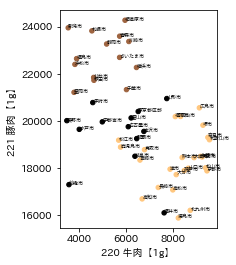

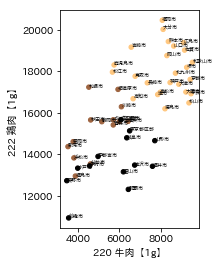

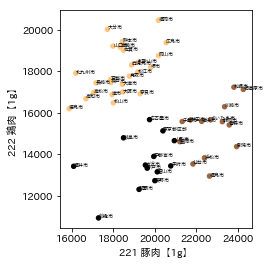

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from sklearn.cluster import KMeans
from matplotlib.backends.backend_pdf import PdfPages
import folium
import itertools

#本サンプルで参照するデータのディレクトリを指定する
DATADIR = './'
encoding = 'shift_JIS'
# % e-Stat の家計調査データ
skiprows = 0  # ヘッダ削除済み
num_items = 226  # まずは全ての列
usecols = [2, 3] + [x + 5 for x in range(num_items)]  # 地域区分，年，品目・・・
# print(usecols)
#家計調査データ(csv)をdataディレクトリに置いておく
csvpath = DATADIR + '/FEH_00200561_190604190707.csv'
df1 = pd.read_csv(csvpath, thousands=',', skiprows=skiprows, usecols=usecols, encoding=encoding)
# print(df1)

# %%
# 列追加前にrawデータと列名を取得
city_raw = df1.iloc[:, 0]
orig_city_colname = df1.columns[0]
year_raw = df1.iloc[:, 1]
orig_year_colname = df1.columns[1]

# %% 都市名と年次を整形
# 都市名のコードを削除
city_new = city_raw.str.replace('[0-9 ]*(.+)', r'\1')
jiscode = city_raw.str.replace('([0-9]*) *.+', r'\1')  # 0から始まるものもあるのでintにしてしまう
# %print(city_new)
# str アクセサを使わず直接 replaceすれば inplace で置換できるはずだが，いったん列を作る
df1['city'] = city_new
df1['jiscode'] = jiscode
df1.drop(orig_city_colname, axis=1, inplace=True)
# 年次の「年」を削除してintへ
# year_new = year_raw.replace('年', '')  # これはだめ
year_new = year_raw.str.replace('年', '').astype(int)
# print(year_new)
df1['year'] = year_new
df1.drop(orig_year_colname, axis=1, inplace=True)

# %% 年の抽出，集計
# df2 = df1[df1['year'] >= 2016]  # 年の抽出
df2 = df1.query('2014 <= year <= 2018')

rows_to_drop = df2.index[df2['city'] == '全国']  # 「全国」の除外
df2 = df2.drop(rows_to_drop)

df2['jiscode'] = df2['jiscode'].astype(int)  # あとで数値として比較する & groupby対策で intへ変換

groupby = df2.groupby('city')  # 複数年の平均
df2 = groupby.mean()

# df2 = (df2 - df2.mean()) / df2.std(ddof=0)  # 標準化

# %% 列を選択してクラスタリング
usecols = [48, 49, 50]  # ３列選ぶ
# collist = [16, 47]  # 魚 vs 肉
data_for_kmeans = df2.iloc[:, usecols].values
pred = KMeans(n_clusters=3).fit_predict(data_for_kmeans)
print(pred)
df2['cluster'] = pred

# % 散布図で確認
# % 散布図は，clustering.pdf に出力される．書籍の〇で囲ったものは出力されたPDFを加工しました．
with PdfPages('clustering.pdf') as pdf_clustering:
    for colpair in itertools.combinations(usecols, 2):
        colname = [df2.columns[c] for c in colpair]

        #ax = df2.plot(kind='scatter', x=colname[0], y=colname[1], c=pred, cmap='brg', colorbar=False)
        ax = df2.plot(kind='scatter', x=colname[0], y=colname[1], c=pred, cmap='copper', colorbar=False)
        for index, row in df2.iterrows():
            # ax.annotate(row['city'], xy=(row[colname[0]], row[colname[1]]), size=6)
            ax.annotate(index, xy=(row[colname[0]], row[colname[1]]), size=5) 
            # ax.colorbar()       
        # ax.set_aspect('equal', 'datalim')
        ax.axis('scaled')

        pdf_clustering.savefig()


# %% 日本地図上にプロット ------------------------------

# % アマノ技研様提供の緯度経度データをあらかじめdataディレクトリに置いておく
# % 最新の地図情報を利用したい場合は適宜作成して下記を修正する．
csvpath = DATADIR + '/r0112puboffice_sjis.csv'  # 経度・緯度情報読み込み

gis_df = pd.read_table(csvpath, encoding=encoding)

# % 地図作成
copyright_st = '&copy; ' \
            'Map tiles by <a href="http://stamen.com">Stamen Design</a>,' \
            ' under <a href="http://creativecommons.org/licenses/by/3.0">CC BY 3.0</a>.' \
            'Data by <a href="http://openstreetmap.org">OpenStreetMap</a>,' \
            'under <a href="http://www.openstreetmap.org/copyright">ODbL</a>.'

center_location = [35, 135]  # 明石市
m = folium.Map(location=center_location,
               attr=copyright_st,
               tiles='https://stamen-tiles-{s}.a.ssl.fastly.net/toner-lite/{z}/{x}/{y}.png',
               zoom_starts=4)

# %% マーカーを立てていく
#colors = ['blue', 'red', 'green']
colors = ['black', 'lightgray', 'beige']

for index, row in df2.iterrows():
    # print(row['jiscode'])
    jcode = row['jiscode']
    if jcode == 13100:
        jcode = 13101  # 東京都特別区 -> 東京都千代田区
    tmp_df = gis_df.query('jiscode == @jcode')
    # print([index, tmp_df['name'].values[0]])
    latlon = [tmp_df['lat'].values[0], tmp_df['lon'].values[0]]
    vals = row.iloc[usecols].astype(str).tolist()  # データ
    names = ['牛', '豚', '鶏']
    name_and_vals = [n + ': ' + v for n, v in zip(names, vals)]
    popup = '<b>' + '<br />'.join([index] + name_and_vals) + '</b>'
    print(popup)
    # print(latlon)
    # print(row['cluster'])  # クラスタリング結果
    folium.Marker(latlon,
                  popup=popup,
                  icon=folium.Icon(color=colors[int(row['cluster'])], icon='info-sign')
                  ).add_to(m)

#地図上にプロットした結果は下記htmlファイルへ出力される．
m.save(outfile='map-clustering.html')

